In [1]:
# PTB-XL Transformer (OSC-Ready) with AFIB Threshold Adjustment

import os
import zipfile
import requests
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import ast
import wfdb
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
# Dataset paths
ptbxl_path = Path("data/raw/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv")
waveform_path = Path("data/raw/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1")


In [3]:
# Load and preprocess

df = pd.read_csv(ptbxl_path)
df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
df['scp_keys'] = df['scp_codes'].apply(lambda x: list(x.keys()))
target_labels = ['NORM', 'AFIB', 'PVC', 'LVH', 'IMI', 'ASMI', 'LAFB', 'IRBBB']
df['scp_filtered'] = df['scp_keys'].apply(lambda x: [k for k in x if k in target_labels])
df = df[df['scp_filtered'].map(len) > 0]

mlb = MultiLabelBinarizer(classes=target_labels)
y = mlb.fit_transform(df['scp_filtered'])

In [4]:
# Stratified split
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in mskf.split(df, y):
    X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    break

In [5]:
# Oversample AFIB
afib_index = target_labels.index('AFIB')
afib_mask = y_train[:, afib_index] == 1
X_afib = X_train[afib_mask]
y_afib = y_train[afib_mask]
X_train = pd.concat([X_train] + [X_afib] * 5, ignore_index=True)
y_train = np.vstack([y_train] + [y_afib] * 5)

In [6]:
# Load ECG signal
def load_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    return record.p_signal.T

In [7]:
# Dataset class
class PTBXL_Dataset(Dataset):
    def __init__(self, df, labels, base_dir):
        self.df = df
        self.labels = labels
        self.base_dir = base_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['filename_lr'])
        signal = load_ecg(full_path).T
        return torch.tensor(signal, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

In [8]:
# Data loaders
train_dataset = PTBXL_Dataset(X_train, y_train, waveform_path)
test_dataset = PTBXL_Dataset(X_test, y_test, waveform_path)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=2, pin_memory=True)

In [9]:
# Transformer model
class ECG_Transformer(nn.Module):
    def __init__(self, seq_len=5000, num_features=12, d_model=32, nhead=2, num_layers=2, num_classes=8):
        super(ECG_Transformer, self).__init__()
        self.input_linear = nn.Linear(num_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.input_linear(x)
        x = self.transformer_encoder(x)
        x = x.permute(0, 2, 1)
        x = self.global_avg_pool(x).squeeze(-1)
        x = self.fc(x)
        return x

In [10]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECG_Transformer().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for signals, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        signals, labels = signals.to(model.fc.weight.device), labels.to(model.fc.weight.device)
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.sigmoid(outputs)
        preds[:, afib_index] = (preds[:, afib_index] > 0.3).float()
        for i in range(preds.shape[1]):
            if i != afib_index:
                preds[:, i] = (preds[:, i] > 0.5).float()
        acc = (preds == labels).float().mean().item()
        correct += acc
        total += 1
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {correct / total:.4f}")

Epoch 1/10: 100%|██████████| 2549/2549 [00:58<00:00, 43.86it/s]


Epoch 1, Loss: 0.3164, Accuracy: 0.8609


Epoch 2/10: 100%|██████████| 2549/2549 [00:58<00:00, 43.82it/s]


Epoch 2, Loss: 0.2625, Accuracy: 0.8844


Epoch 3/10: 100%|██████████| 2549/2549 [00:57<00:00, 44.22it/s]


Epoch 3, Loss: 0.2408, Accuracy: 0.8936


Epoch 4/10: 100%|██████████| 2549/2549 [00:56<00:00, 44.89it/s]


Epoch 4, Loss: 0.2241, Accuracy: 0.9027


Epoch 5/10: 100%|██████████| 2549/2549 [00:56<00:00, 44.86it/s]


Epoch 5, Loss: 0.2105, Accuracy: 0.9092


Epoch 6/10: 100%|██████████| 2549/2549 [00:56<00:00, 45.02it/s]


Epoch 6, Loss: 0.1983, Accuracy: 0.9151


Epoch 7/10: 100%|██████████| 2549/2549 [00:56<00:00, 45.18it/s]


Epoch 7, Loss: 0.1892, Accuracy: 0.9203


Epoch 8/10: 100%|██████████| 2549/2549 [00:57<00:00, 44.25it/s]


Epoch 8, Loss: 0.1786, Accuracy: 0.9260


Epoch 9/10: 100%|██████████| 2549/2549 [00:56<00:00, 44.88it/s]


Epoch 9, Loss: 0.1691, Accuracy: 0.9305


Epoch 10/10: 100%|██████████| 2549/2549 [00:53<00:00, 48.09it/s]

Epoch 10, Loss: 0.1608, Accuracy: 0.9347


In [11]:
# Evaluate
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for signals, labels in test_loader:
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        y_true.append(labels.cpu().numpy())
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

In [12]:
# Apply custom threshold
thresholds = np.full(y_pred.shape[1], 0.5)
thresholds[1] = 0.3  # AFIB
preds = (y_pred > thresholds).astype(int)

In [13]:
# Generate report
print("Classification Report:")
print(classification_report(y_true, preds, target_names=mlb.classes_))
print("Macro ROC-AUC:", roc_auc_score(y_true, y_pred, average='macro'))

Classification Report:
              precision    recall  f1-score   support

        NORM       0.83      0.92      0.87      1906
        AFIB       0.37      0.71      0.49       303
         PVC       0.73      0.65      0.69       229
         LVH       0.72      0.57      0.63       427
         IMI       0.66      0.37      0.48       537
        ASMI       0.74      0.59      0.66       473
        LAFB       0.69      0.85      0.76       325
       IRBBB       0.58      0.64      0.61       223

   micro avg       0.71      0.74      0.72      4423
   macro avg       0.66      0.66      0.65      4423
weighted avg       0.73      0.74      0.72      4423
 samples avg       0.75      0.77      0.74      4423

Macro ROC-AUC: 0.9325960384436158


/users/PLS0151/nicholaskanos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


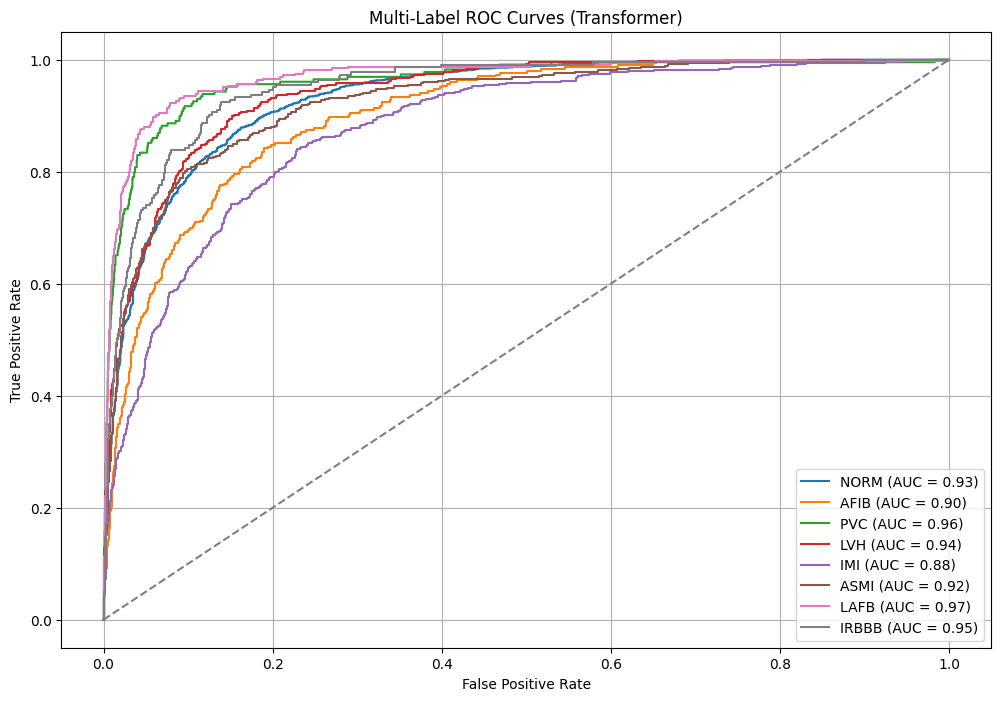

In [14]:
# ROC Curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(mlb.classes_):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Label ROC Curves (Transformer)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [15]:
 # Helper function to compute macro-average ROC
def compute_macro_roc(y_true, y_pred):
    from sklearn.metrics import roc_curve, auc
    import numpy as np

    n_classes = y_true.shape[1]
    fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}

    for i in range(n_classes):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    return all_fpr, mean_tpr, macro_auc

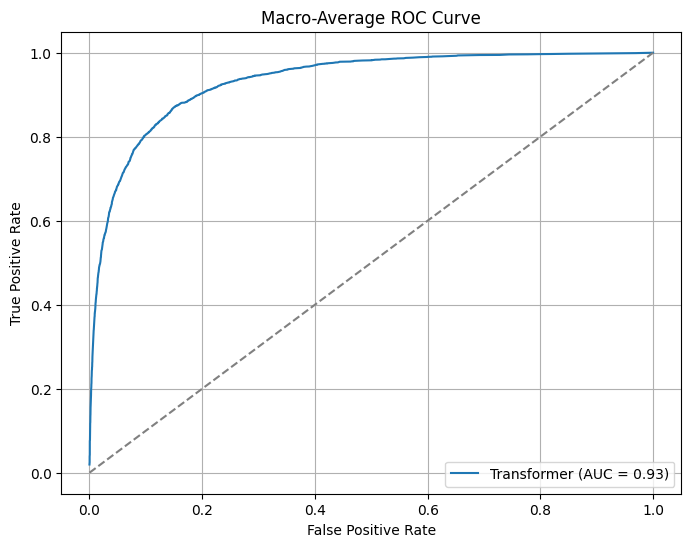

In [16]:
# Plot macro-average ROC
fpr, tpr, macro_auc = compute_macro_roc(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Transformer (AUC = {macro_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Macro-Average ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [17]:
import numpy as np

# After evaluation
np.save("y_true_transformer.npy", y_true)
np.save("y_pred_transformer.npy", y_pred)
